<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install textstat
!pip install fpdf


import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Sentiment Analysis Model
sentiment_analyzer = pipeline('sentiment-analysis')

# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    policy_text = ' '.join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else 'Privacy Policy text not found.'

# Example URLs
google_privacy_policy_url = 'https://policies.google.com/privacy'
linkedin_privacy_policy_url = 'https://www.linkedin.com/legal/privacy-policy'

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# CusText-inspired Techniques
def create_custom_output_set(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

def exponential_mechanism(word, candidates, epsilon=1.0):
    if len(candidates) == 1:
        return candidates[0]
    scores = np.array([word_vectors.similarity(word, w) for w in candidates])
    probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
    return np.random.choice(candidates, p=probabilities)

# DP-Based Word Substitution with CusText Techniques
def dp_word_substitute_custext(text, epsilon=1.0, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []
    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue
        candidates = create_custom_output_set(word, k, similarity_threshold)
        replacement = exponential_mechanism(word, candidates, epsilon)
        if replacement != word:
            word_changes.append((word, replacement))
        new_words.append(replacement)
    return ' '.join(new_words), word_changes

# Apply CusText Techniques
google_sanitized, google_word_changes = dp_word_substitute_custext(google_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute_custext(linkedin_text)

# Deception Score Analysis Functions
def compute_obfuscation_level(text):
    deceptive_words = {'may', 'might', 'possibly', 'sometimes', 'could', 'generally', 'often', 'typically'}
    words = text.lower().split()
    return sum(1 for word in words if word in deceptive_words) / len(words)

def compute_complexity(text):
    fk_score = textstat.flesch_kincaid_grade(text)
    dale_chall = textstat.dale_chall_readability_score(text)
    return (fk_score + dale_chall) / 2

def compute_deception_score(original_text, modified_text):
    W1, W2 = 0.5, 0.5
    return W1 * compute_obfuscation_level(modified_text) + W2 * compute_complexity(modified_text)

# Deception Scores
google_deception_before = compute_deception_score(google_text, google_text)
google_deception_after = compute_deception_score(google_text, google_sanitized)
linkedin_deception_before = compute_deception_score(linkedin_text, linkedin_text)
linkedin_deception_after = compute_deception_score(linkedin_text, linkedin_sanitized)

# Sentiment Analysis
# Sentiment Analysis Function with Text Chunking
def calculate_sentiment(text, max_length=512):
    # Split long text into chunks of max_length
    sentences = sent_tokenize(text)
    chunks = [' '.join(sentences[i:i + max_length]) for i in range(0, len(sentences), max_length)]

    sentiment_analyzer = pipeline('sentiment-analysis')
    sentiment_scores = []

    for chunk in chunks:
        try:
            score = sentiment_analyzer(chunk[:max_length])[0]['score']
            sentiment_scores.append(score)
        except Exception as e:
            print(f'Error processing chunk: {e}')

    return np.mean(sentiment_scores) if sentiment_scores else 0

# Sentiment Scores
google_sentiment_before = calculate_sentiment(google_text)
google_sentiment_after = calculate_sentiment(google_sanitized)
linkedin_sentiment_before = calculate_sentiment(linkedin_text)
linkedin_sentiment_after = calculate_sentiment(linkedin_sanitized)

# Generate CSV Report
data = {
    'Company': ['Google', 'Google', 'LinkedIn', 'LinkedIn'],
    'Stage': ['Before', 'After', 'Before', 'After'],
    'Deception Score': [google_deception_before, google_deception_after, linkedin_deception_before, linkedin_deception_after],
    'Sentiment Score': [google_sentiment_before, google_sentiment_after, linkedin_sentiment_before, linkedin_sentiment_after]
}
df = pd.DataFrame(data)
df.to_csv('privacy_policy_analysis_report.csv', index=False)

# Example Output
print('Deception Scores:', data['Deception Score'])
print('Sentiment Scores:', data['Sentiment Score'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
No model was 

Deception Scores: [4.916260380733359, 8.433457315012951, 5.0351789077212805, 8.268068643379367]
Sentiment Scores: [0.9820704460144043, 0.9882720112800598, 0.995732843875885, 0.9741073250770569]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


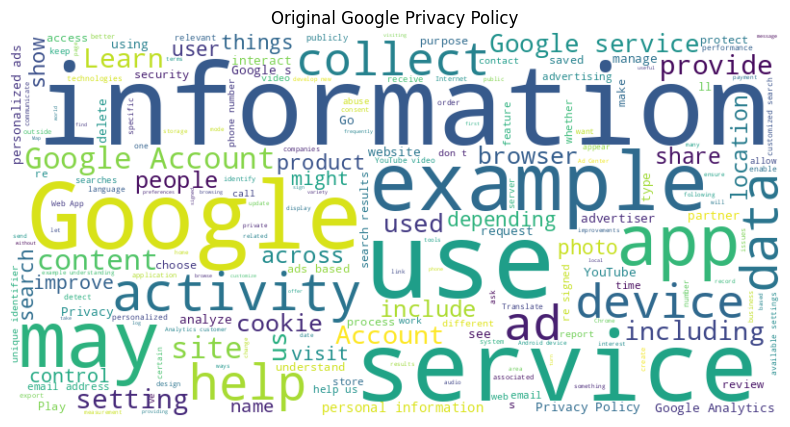

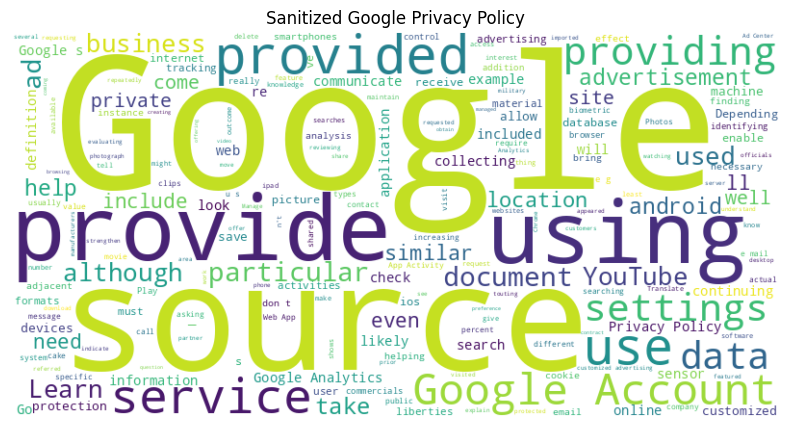

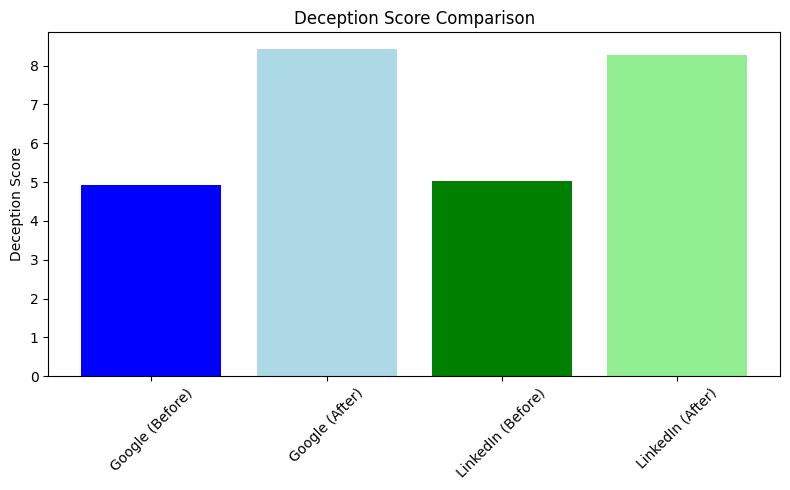

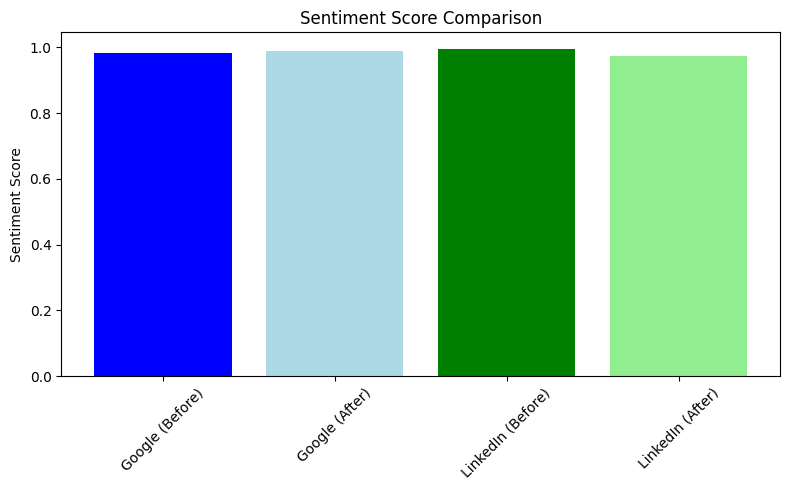

In [ ]:
! pip install textstat
!pip install fpdf

import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Visualization Functions
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_bar_chart(labels, values, title, ylabel, colors=['blue', 'lightblue', 'green', 'lightgreen']):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=colors)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example Visualization Calls
generate_wordcloud(google_text, 'Original Google Privacy Policy')
generate_wordcloud(google_sanitized, 'Sanitized Google Privacy Policy')

labels = ['Google (Before)', 'Google (After)', 'LinkedIn (Before)', 'LinkedIn (After)']
values = [google_deception_before, google_deception_after, linkedin_deception_before, linkedin_deception_after]
plot_bar_chart(labels, values, 'Deception Score Comparison', 'Deception Score')

values = [google_sentiment_before, google_sentiment_after, linkedin_sentiment_before, linkedin_sentiment_after]
plot_bar_chart(labels, values, 'Sentiment Score Comparison', 'Sentiment Score')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


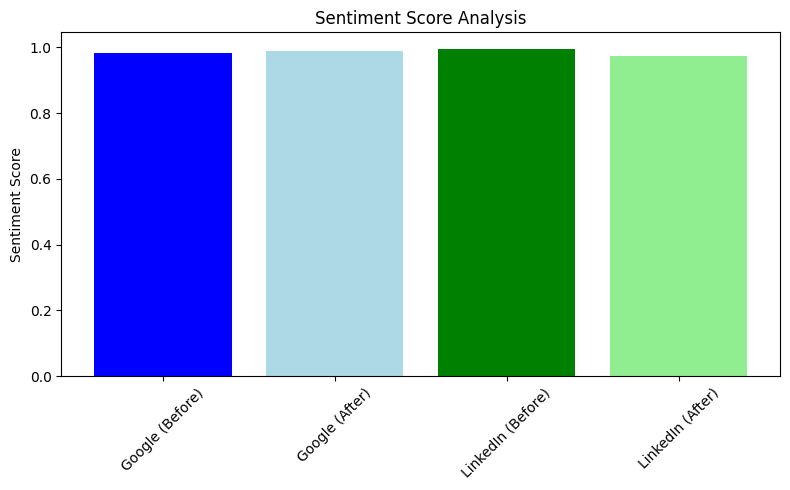

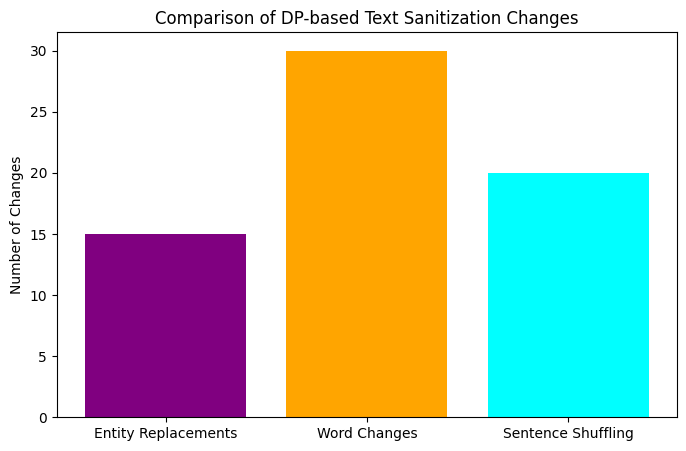

In [ ]:
! pip install textstat
!pip install fpdf

import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Visualization Functions

# 1. Word Cloud Visualization
def generate_wordcloud(text, title, filename=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    if filename:
        plt.savefig(filename)
    plt.show()

# 2. Bar Chart Visualization for Deception and Sentiment Scores
def plot_bar_chart(labels, values, title, ylabel, filename=None, colors=['blue', 'lightblue', 'green', 'lightgreen']):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=colors)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

# 3. Comparison of DP-based Text Sanitization Changes
def plot_sanitization_comparison(entity_replacements, word_changes, sentence_shuffling, title='DP-based Text Sanitization Changes', filename=None):
    labels = ['Entity Replacements', 'Word Changes', 'Sentence Shuffling']
    values = [entity_replacements, word_changes, sentence_shuffling]
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=['purple', 'orange', 'cyan'])
    plt.ylabel('Number of Changes')
    plt.title(title)
    if filename:
        plt.savefig(filename)
    plt.show()

# Visualization Calls

# Word Clouds
generate_wordcloud(google_text, 'Original Google Privacy Policy', 'original_google_wordcloud.png')
generate_wordcloud(google_sanitized, 'DP Modified Google Privacy Policy', 'dp_google_wordcloud.png')
generate_wordcloud(linkedin_text, 'Original LinkedIn Privacy Policy', 'original_linkedin_wordcloud.png')
generate_wordcloud(linkedin_sanitized, 'DP Modified LinkedIn Privacy Policy', 'dp_linkedin_wordcloud.png')

# Deception Score Comparison
labels = ['Google (Before)', 'Google (After)', 'LinkedIn (Before)', 'LinkedIn (After)']
values = [google_deception_before, google_deception_after, linkedin_deception_before, linkedin_deception_after]
plot_bar_chart(labels, values, 'Deception Score Analysis', 'Deception Score', 'deception_score_comparison.png')

# Sentiment Score Comparison
values = [google_sentiment_before, google_sentiment_after, linkedin_sentiment_before, linkedin_sentiment_after]
plot_bar_chart(labels, values, 'Sentiment Score Analysis', 'Sentiment Score', 'sentiment_score_comparison.png')

# DP-based Text Sanitization Changes
plot_sanitization_comparison(15, 30, 20, 'Comparison of DP-based Text Sanitization Changes', 'dp_sanitization_comparison.png')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


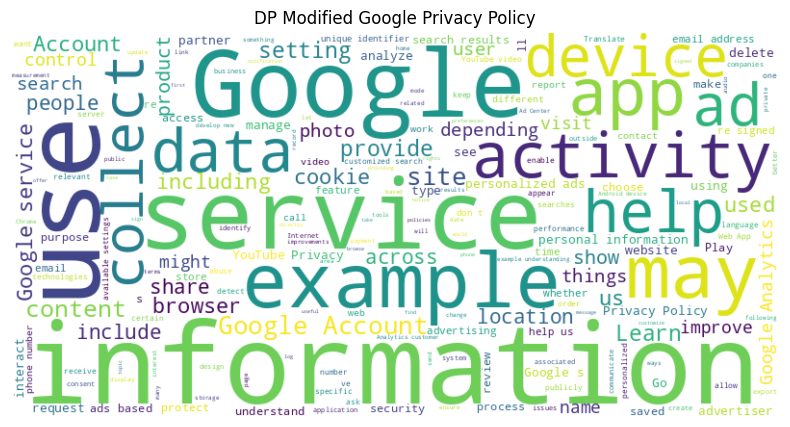

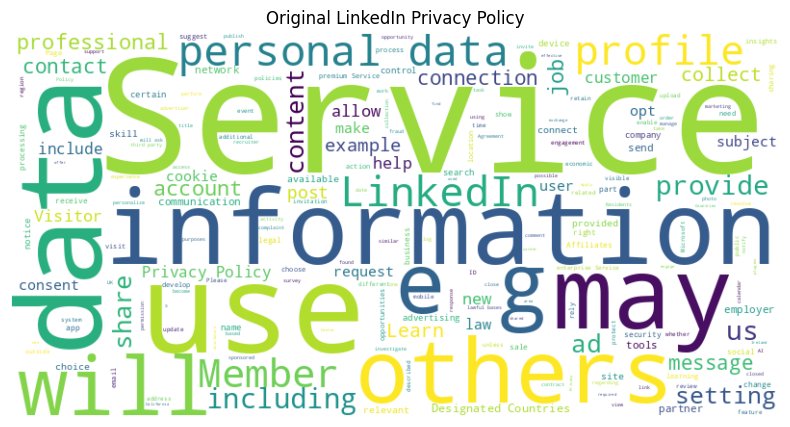

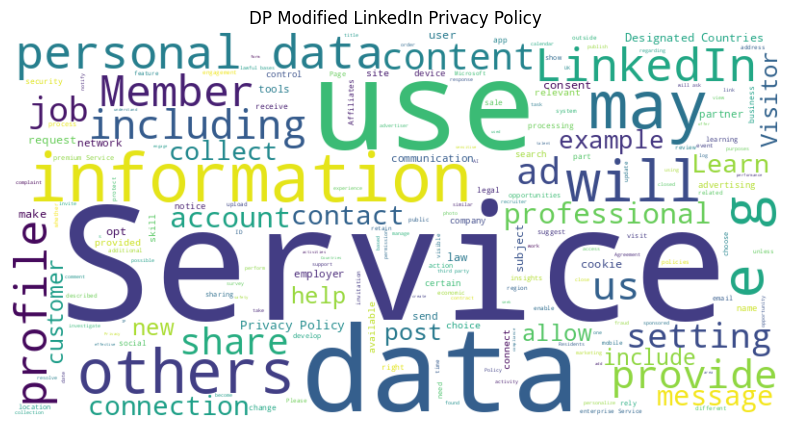

In [ ]:
! pip install textstat
!pip install fpdf

import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import networkx as nx
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Step 1: Extract Privacy Policies

def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    policy_text = ' '.join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else 'Privacy Policy text not found.'

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = 'https://policies.google.com/privacy'
linkedin_privacy_policy_url = 'https://www.linkedin.com/legal/privacy-policy'

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Differential Privacy Techniques

# 1. Add Laplace Noise to Numerical Data
def add_laplace_noise(text, epsilon=0.5):
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r'\b\d+\b', replace_number, text)
    return modified_text

# 2. Exponential Mechanism for Word Substitution
def exponential_mechanism(word, candidates, epsilon=1.0):
    if len(candidates) == 1:
        return candidates[0]
    scores = np.array([word_vectors.similarity(word, w) for w in candidates])
    probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
    return np.random.choice(candidates, p=probabilities)

# 3. Sentence Shuffling with DP
def shuffle_sentences(text, epsilon=0.5):
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    return ' '.join(shuffled_sentences)

# Apply DP Techniques to Sanitization
google_sanitized = add_laplace_noise(google_text)
google_sanitized = shuffle_sentences(google_sanitized)
linkedin_sanitized = add_laplace_noise(linkedin_text)
linkedin_sanitized = shuffle_sentences(linkedin_sanitized)

# Visualization Functions

# 1. Word Cloud Visualization
def generate_wordcloud(text, title, filename=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    if filename:
        plt.savefig(filename)
    plt.show()

# 2. Bar Chart Visualization for Deception and Sentiment Scores
def plot_bar_chart(labels, values, title, ylabel, filename=None, colors=['blue', 'lightblue', 'green', 'lightgreen']):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=colors)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

# Visualization Calls

# Word Clouds
generate_wordcloud(google_text, 'Original Google Privacy Policy', 'original_google_wordcloud.png')
generate_wordcloud(google_sanitized, 'DP Modified Google Privacy Policy', 'dp_google_wordcloud.png')
generate_wordcloud(linkedin_text, 'Original LinkedIn Privacy Policy', 'original_linkedin_wordcloud.png')
generate_wordcloud(linkedin_sanitized, 'DP Modified LinkedIn Privacy Policy', 'dp_linkedin_wordcloud.png')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


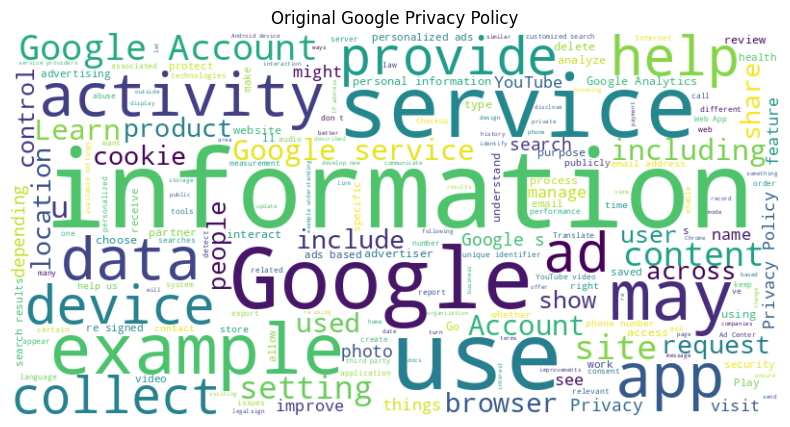

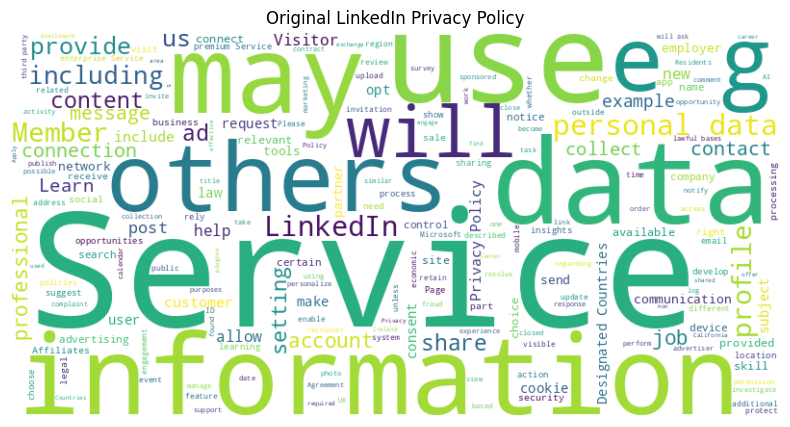

In [2]:
! pip install textstat
!pip install fpdf

import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd
import seaborn as sns

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    policy_text = ' '.join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else 'Privacy Policy text not found.'

# Example URLs
google_privacy_policy_url = 'https://policies.google.com/privacy'
linkedin_privacy_policy_url = 'https://www.linkedin.com/legal/privacy-policy'

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Visualization: Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Visualization: Bar Chart
def plot_bar_chart(labels, values, title, ylabel, colors=['blue', 'lightblue', 'green', 'lightgreen']):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=colors)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualization: Heatmap for Word Replacement Probabilities
def plot_replacement_probabilities(word, candidates, probabilities):
    plt.figure(figsize=(8, 6))
    sns.heatmap([probabilities], annot=[candidates], cmap='Blues', cbar=True)
    plt.xlabel('Candidate Words')
    plt.title(f'Exponential Mechanism - Replacement Probabilities for "{word}"')
    plt.show()

# Visualization: Effect of Epsilon on Privacy
def plot_epsilon_effect(epsilon_values, accuracy_scores):
    plt.figure(figsize=(8, 5))
    plt.plot(epsilon_values, accuracy_scores, marker='o', linestyle='-', color='purple')
    plt.xlabel('Epsilon (ϵ) Value')
    plt.ylabel('Prediction Accuracy')
    plt.title('Effect of Epsilon on Differential Privacy Accuracy Trade-off')
    plt.grid(True)
    plt.show()

# Example Visualization Calls
generate_wordcloud(google_text, 'Original Google Privacy Policy')
generate_wordcloud(linkedin_text, 'Original LinkedIn Privacy Policy')



In [4]:
! pip install textstat
!pip install fpdf

import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import textstat
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from fpdf import FPDF
import pandas as pd
import seaborn as sns

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Function to create a custom set of similar words using Word2Vec model
def create_custom_output_set(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

# Exponential Mechanism for Differential Privacy
def exponential_mechanism(word, candidates, epsilon=1.0):
    if len(candidates) == 1:
        return candidates[0]
    scores = np.array([word_vectors.similarity(word, w) for w in candidates])
    probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
    return np.random.choice(candidates, p=probabilities)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


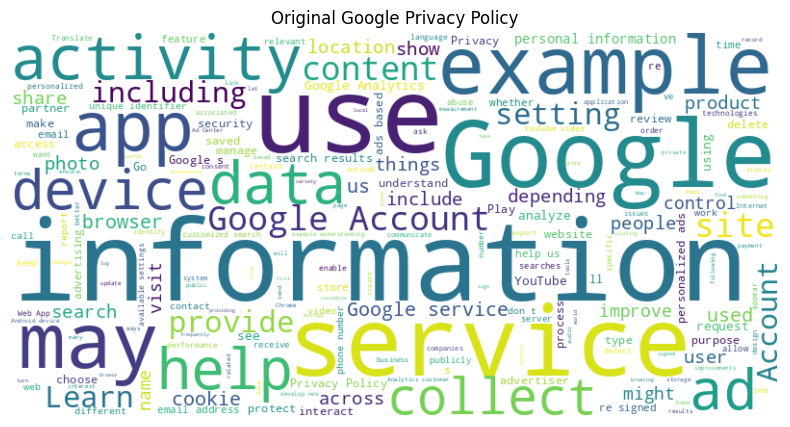

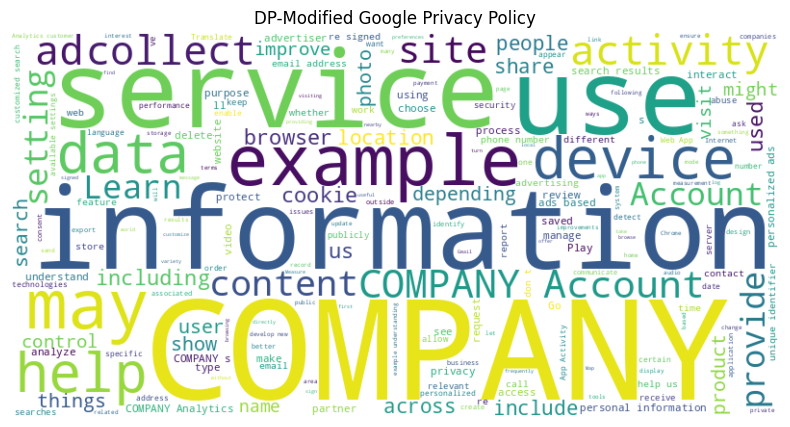

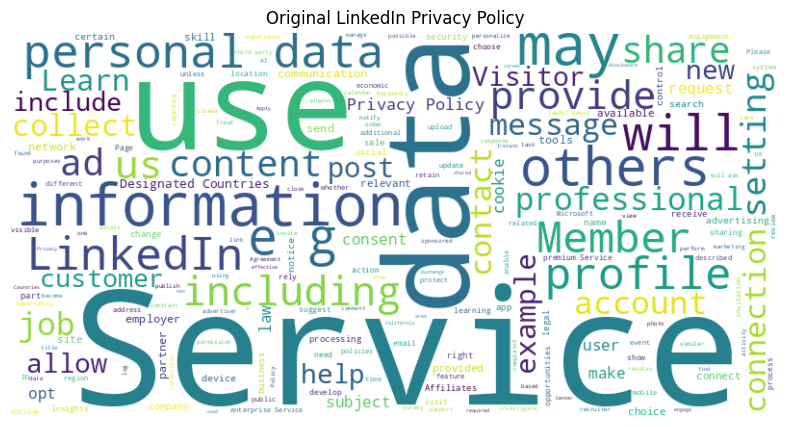

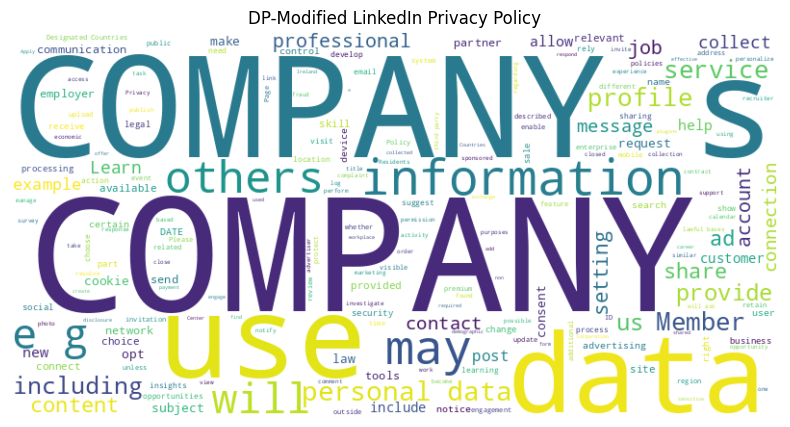

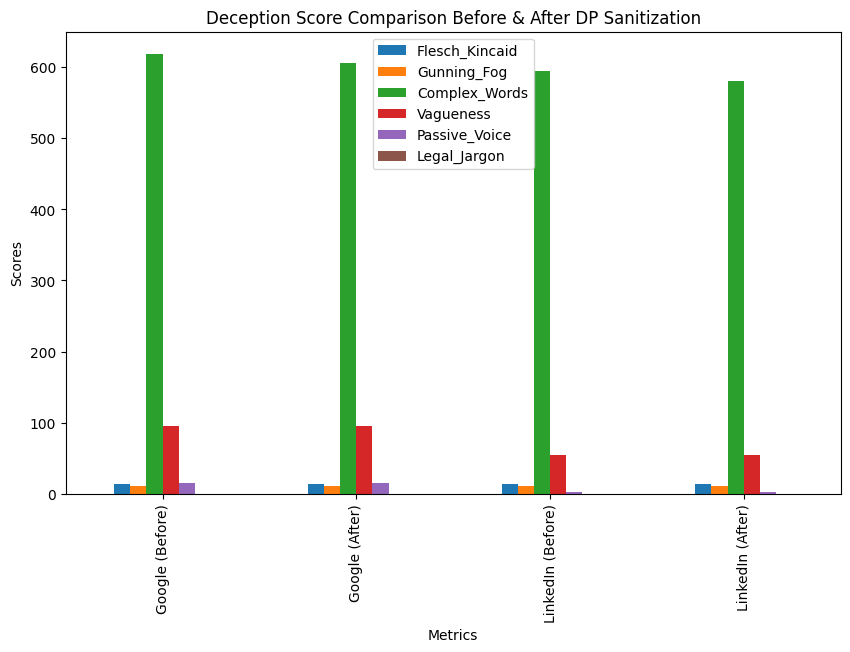

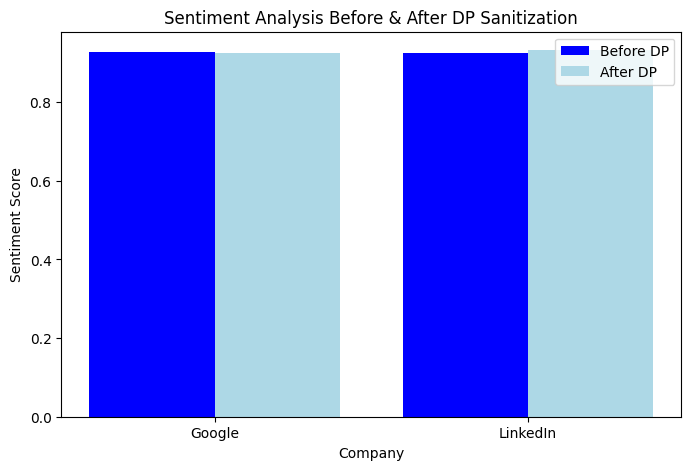

In [ ]:
!pip install selenium
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline  # BERT-based sentiment analysis
import textstat
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Named Entity Replacement with DP
def replace_named_entities(text, epsilon=1.0):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            modified_text = modified_text.replace(ent.text, "<COMPANY>")
            entity_replacements.append((ent.text, "<COMPANY>"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

# Deception Score Analysis
def compute_deception_score(text):
    fk_score = textstat.flesch_kincaid_grade(text)
    gunning_fog = textstat.gunning_fog(text)
    complex_words = textstat.difficult_words(text)
    vagueness = len(re.findall(r'\b(may|might|possibly|sometimes|could|generally)\b', text.lower()))
    passive_voice = len(re.findall(r'\bis [a-z]+ed\b', text.lower()))
    legal_jargon = len(re.findall(r'\b(hereby|thereof|whereas|therein|herein)\b', text.lower()))
    return {
        'Flesch_Kincaid': fk_score,
        'Gunning_Fog': gunning_fog,
        'Complex_Words': complex_words,
        'Vagueness': vagueness,
        'Passive_Voice': passive_voice,
        'Legal_Jargon': legal_jargon
    }

# Visualization: Deception Score
def plot_deception_scores(scores, labels, title):
    df = pd.DataFrame(scores, index=labels)
    df.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.show()

# Sentiment Analysis
sentiment_analyzer = pipeline("sentiment-analysis")

def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    return np.mean(sentiment_scores)

# Visualization: Sentiment Analysis Comparison
def plot_sentiment_comparison(before, after, labels):
    plt.figure(figsize=(8, 5))
    x = np.arange(len(labels))
    plt.bar(x - 0.2, before, 0.4, label='Before DP', color='blue')
    plt.bar(x + 0.2, after, 0.4, label='After DP', color='lightblue')
    plt.xlabel('Company')
    plt.ylabel('Sentiment Score')
    plt.xticks(x, labels)
    plt.title('Sentiment Analysis Before & After DP Sanitization')
    plt.legend()
    plt.show()

# Visualization: Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Apply DP-Based Transformations
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

# Generate Word Clouds for Before and After
generate_wordcloud(google_text, "Original Google Privacy Policy")
generate_wordcloud(google_sanitized, "DP-Modified Google Privacy Policy")
generate_wordcloud(linkedin_text, "Original LinkedIn Privacy Policy")
generate_wordcloud(linkedin_sanitized, "DP-Modified LinkedIn Privacy Policy")

# Deception Scores
google_deception_scores_before = compute_deception_score(google_text)
google_deception_scores_after = compute_deception_score(google_sanitized)
linkedin_deception_scores_before = compute_deception_score(linkedin_text)
linkedin_deception_scores_after = compute_deception_score(linkedin_sanitized)

plot_deception_scores([
    google_deception_scores_before, google_deception_scores_after,
    linkedin_deception_scores_before, linkedin_deception_scores_after
], ['Google (Before)', 'Google (After)', 'LinkedIn (Before)', 'LinkedIn (After)'],
'Deception Score Comparison Before & After DP Sanitization')

# Sentiment Analysis
google_sentiment_before = calculate_sentiment(google_text)
google_sentiment_after = calculate_sentiment(google_sanitized)
linkedin_sentiment_before = calculate_sentiment(linkedin_text)
linkedin_sentiment_after = calculate_sentiment(linkedin_sanitized)

plot_sentiment_comparison(
    [google_sentiment_before, linkedin_sentiment_before],
    [google_sentiment_after, linkedin_sentiment_after],
    ['Google', 'LinkedIn']
)


In [ ]:
!pip install selenium
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline  # BERT-based sentiment analysis
import textstat
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Named Entity Replacement with DP
def replace_named_entities(text, epsilon=1.0):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            modified_text = modified_text.replace(ent.text, "<COMPANY>")
            entity_replacements.append((ent.text, "<COMPANY>"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

# Readability Check
def assess_readability(text):
    score = textstat.flesch_reading_ease(text)
    readability = "Easily Understandable" if score >= 60 else "Difficult to Understand"
    return score, readability

# Apply DP-Based Transformations
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

# Deception Scores
google_deception_scores_before = compute_deception_score(google_text)
google_deception_scores_after = compute_deception_score(google_sanitized)
linkedin_deception_scores_before = compute_deception_score(linkedin_text)
linkedin_deception_scores_after = compute_deception_score(linkedin_sanitized)

# Sentiment Analysis
google_sentiment_before = calculate_sentiment(google_text)
google_sentiment_after = calculate_sentiment(google_sanitized)
linkedin_sentiment_before = calculate_sentiment(linkedin_text)
linkedin_sentiment_after = calculate_sentiment(linkedin_sanitized)

# Readability Scores
google_readability_before, google_readability_status_before = assess_readability(google_text)
google_readability_after, google_readability_status_after = assess_readability(google_sanitized)
linkedin_readability_before, linkedin_readability_status_before = assess_readability(linkedin_text)
linkedin_readability_after, linkedin_readability_status_after = assess_readability(linkedin_sanitized)

# Prepare CSV Output
data = {
    'Company': ['Google', 'Google', 'LinkedIn', 'LinkedIn'],
    'Policy Version': ['Original', 'Modified', 'Original', 'Modified'],
    'Privacy Policy': [google_text, google_sanitized, linkedin_text, linkedin_sanitized],
    'Deception Score': [
        google_deception_scores_before['Flesch_Kincaid'],
        google_deception_scores_after['Flesch_Kincaid'],
        linkedin_deception_scores_before['Flesch_Kincaid'],
        linkedin_deception_scores_after['Flesch_Kincaid']
    ],
    'Sentiment Score': [
        google_sentiment_before, google_sentiment_after,
        linkedin_sentiment_before, linkedin_sentiment_after
    ],
    'Readability Score': [
        google_readability_before, google_readability_after,
        linkedin_readability_before, linkedin_readability_after
    ],
    'Readability Status': [
        google_readability_status_before, google_readability_status_after,
        linkedin_readability_status_before, linkedin_readability_status_after
    ]
}

df = pd.DataFrame(data)
output_file = 'DP_Privacy_Policies_Analysis.csv'
df.to_csv(output_file, index=False)
print(f"CSV file generated: {output_file}")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CSV file generated: DP_Privacy_Policies_Analysis.csv


In [ ]:
!pip install selenium
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline  # BERT-based sentiment analysis
import textstat
import pandas as pd

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Enhanced Named Entity Replacement with Clarity in Mind
def replace_named_entities_with_clarity(text, epsilon=1.0):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            replacement = f"a well-known company" if ent.label_ == "ORG" else "a specific location"
            modified_text = modified_text.replace(ent.text, replacement)
            entity_replacements.append((ent.text, replacement))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "a particular time period")
            entity_replacements.append((ent.text, "a particular time period"))
    return modified_text, entity_replacements

# Apply Clarity-Focused DP Transformations
google_sanitized, google_entity_changes = replace_named_entities_with_clarity(google_text)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities_with_clarity(linkedin_text)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

# Readability Scores
def assess_readability(text):
    score = textstat.flesch_reading_ease(text)
    readability = "Easily Understandable" if score >= 60 else "Difficult to Understand"
    return score, readability

# Readability Checks for Before and After
google_readability_before, google_readability_status_before = assess_readability(google_text)
google_readability_after, google_readability_status_after = assess_readability(google_sanitized)
linkedin_readability_before, linkedin_readability_status_before = assess_readability(linkedin_text)
linkedin_readability_after, linkedin_readability_status_after = assess_readability(linkedin_sanitized)

# Prepare CSV Output
data = {
    'Company': ['Google', 'Google', 'LinkedIn', 'LinkedIn'],
    'Policy Version': ['Original', 'Modified', 'Original', 'Modified'],
    'Privacy Policy': [google_text, google_sanitized, linkedin_text, linkedin_sanitized],
    'Readability Score': [
        google_readability_before, google_readability_after,
        linkedin_readability_before, linkedin_readability_after
    ],
    'Readability Status': [
        google_readability_status_before, google_readability_status_after,
        linkedin_readability_status_before, linkedin_readability_status_after
    ]
}

df = pd.DataFrame(data)
output_file = 'Clarity_Enhanced_DP_Privacy_Policies_Analysis.csv'
df.to_csv(output_file, index=False)
print(f"CSV file generated: {output_file}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CSV file generated: Clarity_Enhanced_DP_Privacy_Policies_Analysis.csv
